In [36]:
import random
from collections import deque
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter

## Adaptive Random sampling

Compute the single-source dependency scores $δ_s(v)$ for all vertices v in G using the unweighted version of Brandes' algorithm.

In [37]:
def brandes_single_source_dependencies_unweighted(G, s):
    S = []
    P = {v: [] for v in G}
    sigma = dict.fromkeys(G, 0.0)
    dist  = dict.fromkeys(G, -1)

    sigma[s] = 1.0
    dist[s] = 0

    from collections import deque
    Q = deque([s])

    while Q:
        v = Q.popleft()
        S.append(v)
        for w in G[v]:
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                P[w].append(v)

    delta = dict.fromkeys(G, 0.0)
    while S:
        w = S.pop()
        for v in P[w]:
            if sigma[w] != 0:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])

    return delta

In [38]:
def approx_bc_algorithm1_random(G, c=5.0, cutoff_factor=20, seed=0):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    max_bfs = max(1, n // cutoff_factor)
    print(f"[approx] adaptive + cutoff: max {max_bfs} BFS runs (n/{cutoff_factor}), c={c}")

    S = {v: 0.0 for v in nodes}      
    k = {v: 0   for v in nodes}    
    done = {v: False for v in nodes} 
    remaining = n                 

    bfs_used = 0
    t0 = perf_counter()

    while bfs_used < max_bfs and remaining > 0:
        s = rng.choice(nodes)
        delta = brandes_single_source_dependencies_unweighted(G, s)
        bfs_used += 1

        for v in nodes:
            if done[v] or v == s:
                continue
            S[v] += delta[v]
            k[v] += 1
            if S[v] >= c * n:
                done[v] = True
                remaining -= 1

        if bfs_used % 10 == 0 or bfs_used == max_bfs:
            print(f"[approx] BFS {bfs_used}/{max_bfs}, remaining not-done vertices: {remaining}")

    t1 = perf_counter()
    print(f"[approx] finished in {t1 - t0:.2f}s, BFS_used={bfs_used}")

    bc_hat = {
        v: (n * S[v] / k[v]) if k[v] > 0 else 0.0
        for v in nodes
    }
    return bc_hat, k, bfs_used

In [39]:
def smooth_series(y, window=51):
    w = max(3, int(window))
    if w % 2 == 0:
        w += 1
    if w > len(y):
        w = len(y) if len(y) % 2 == 1 else len(y) - 1
        if w < 3:
            return np.array(y, dtype=float)
    kernel = np.ones(w) / w
    ypad = np.pad(y, (w // 2, w // 2), mode='edge')
    return np.convolve(ypad, kernel, mode='valid')

## Degree-based sampling

In [40]:
def approx_bc_algorithm1_degree_based(G, c=5.0, cutoff_factor=20, alpha=1.0, seed=0):
    """
    Adaptive sampling with degree-based pivot selection:
    Pr(s=v) ∝ (deg(v))^alpha

    alpha = 0 → uniform sampling
    alpha = 1 → linear degree-based sampling
    alpha > 1 → stronger bias toward high-degree hubs
    """

    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    # ----- compute degree^alpha -----
    degs = np.array([G.degree(v) for v in nodes], dtype=float)

    # compute (deg)^alpha
    if alpha == 0:
        # exact uniform sampling
        weights = np.ones(n, dtype=float)
    else:
        weights = np.power(degs, alpha)

    # fallback: if all weights are 0 (rare), use uniform
    if np.all(weights == 0):
        probs = np.ones(n, dtype=float) / n
    else:
        probs = weights / weights.sum()

    # cumulative distribution for sampling
    cum_probs = np.cumsum(probs)

    def sample_source():
        """Sample a source based on degree according to Pr(s=v) ∝ (deg(v))^alpha."""
        x = rng.random()
        idx = np.searchsorted(cum_probs, x, side="left")
        if idx >= n:
            idx = n - 1
        return nodes[idx]

    # adaptive sampling + cutoff 
    max_bfs = max(1, n // cutoff_factor)
    print(f"[approx-alpha-degree] max {max_bfs} BFS runs, c={c}, alpha={alpha}")

    S = {v: 0.0 for v in nodes}
    k = {v: 0   for v in nodes}
    done = {v: False for v in nodes}
    remaining = n

    bfs_used = 0
    t0 = perf_counter()

    while bfs_used < max_bfs and remaining > 0:

        s = sample_source()  #  sampling changed

        delta = brandes_single_source_dependencies_unweighted(G, s)
        bfs_used += 1

        for v in nodes:
            if done[v] or v == s:
                continue
            S[v] += delta[v]
            k[v] += 1
            if S[v] >= c * n:
                done[v] = True
                remaining -= 1

        if bfs_used % 10 == 0 or bfs_used == max_bfs:
            print(f"[approx-alpha-degree] BFS {bfs_used}/{max_bfs}, remaining={remaining}")

    t1 = perf_counter()
    print(f"[approx-alpha-degree] finished in {t1 - t0:.2f}s")

    bc_hat = {
        v: (n * S[v] / k[v]) if k[v] > 0 else 0.0
        for v in nodes
    }
    return bc_hat, k, bfs_used

Function to Plot Figure 1

In [42]:
def plot_fig1(exact_bc, approx_bc_rand, approx_bc_deg, title_suffix="CA-AstroPh"):

    # 1. rank vertices by exact BC
    nodes_sorted = sorted(exact_bc.keys(), key=lambda v: exact_bc[v])
    x = np.arange(len(nodes_sorted))

    # 2. get y values
    y_exact  = np.array([exact_bc[v]       for v in nodes_sorted])
    y_rand   = np.array([approx_bc_rand[v] for v in nodes_sorted])
    y_deg    = np.array([approx_bc_deg[v]  for v in nodes_sorted])

    # 3. smooth the two approx series to reduce jaggedness
    y_rand_smooth = smooth_series(y_rand, window=max(31, len(y_rand)//50))
    y_deg_smooth  = smooth_series(y_deg,  window=max(31, len(y_deg)//50))

    # 4. plot
    plt.figure(figsize=(7, 4))

    # exact uses scatter
    plt.scatter(x, y_exact, s=5, alpha=0.6, label="Exact (Brandes)")

    # random & degree-based use smoothed lines
    plt.plot(x, y_rand_smooth, "r--", lw=1.8, label="Random adaptive (c=5)")
    plt.plot(x, y_deg_smooth,  "g-.", lw=1.8, label="Degree-based adaptive (c=5)")

    plt.yscale("log")  # y-axis log scale
    plt.xlabel("Vertices (sorted by exact betweenness)")
    plt.ylabel("Betweenness centrality")
    plt.title(f"{title_suffix} – Betweenness distribution")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Function to plot fig 2

In [44]:
def plot_bc_error_two_methods(
    exact_bc,
    approx_bc_deg,
    approx_bc_rand,
    top_k=30,
    label_deg="Degree-based sampling",
    label_rand="Adaptive random sampling",
    color_deg="green",
    color_rand="red",
    title=None,
):
    """
    Plot percentage approximation error for top-k high-centrality vertices
    AND print the full comparison table (exact vs approx).

    exact_bc      : dict, node -> exact betweenness
    approx_bc_deg : dict, node -> approx betweenness (degree-based)
    approx_bc_rand: dict, node -> approx betweenness (random/adaptive)
    """

    
    # top-k nodes by exact BC
    top_nodes = sorted(exact_bc, key=exact_bc.get, reverse=True)[:top_k]

    
    #  Compute errors + print table
    '''
    print("\n===== Top-{} Betweenness Centrality Comparison =====".format(top_k))
    print(f"{'Rank':<6}{'Node':<10}{'Exact BC':<15}{'Rand approx':<15}{'Deg approx':<15}{'Rand err %':<12}{'Deg err %':<12}")
    print("-" * 90)
'''
    err_deg = []
    err_rand = []

    for rank, v in enumerate(top_nodes, start=1):
        exact_val = exact_bc[v]
        rand_val = approx_bc_rand.get(v, 0.0)
        deg_val  = approx_bc_deg.get(v, 0.0)

        if exact_val == 0:
            e_rand = 0.0
            e_deg  = 0.0
        else:
            e_rand = abs(rand_val - exact_val) / exact_val * 100
            e_deg  = abs(deg_val  - exact_val) / exact_val * 100

        err_rand.append(e_rand)
        err_deg.append(e_deg)

        # ----- print row -----
        #print(f"{rank:<6}{v:<10}{exact_val:<15.2f}{rand_val:<15.2f}{deg_val:<15.2f}{e_rand:<12.2f}{e_deg:<12.2f}")

   # print("=" * 90 + "\n")


    #  Plot Figure 2
    x = np.arange(1, top_k + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(x, err_deg, marker="o", label=label_deg, color=color_deg)
    plt.plot(x, err_rand, marker="o", label=label_rand, color=color_rand)

    plt.xlabel("High-centrality vertices (ranked by exact BC)")
    plt.ylabel("Approximate centrality error (%)")
    plt.xticks(x)

    ymax = max(err_deg + err_rand)
    plt.ylim(0, ymax * 1.15)

    if title:
        plt.title(title)

    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

Function to plot fig 3, the percentage of BFS/SSSP computations required for ap-
proximating the centrality scores

In [45]:
def plot_bfs_percentages(
    G,
    exact_bc,
    k_used_deg,
    k_used_rand,
    top_k=30,
    label_deg="Degree-based sampling",
    label_rand="Adaptive random sampling",
    color_deg="green",
    color_rand="red",
    title=None
):
    """
    Plot sampling percentage for top-k high-centrality nodes
    based on exact betweenness centrality ranking.

    Parameters
    ----------
    G : networkx.Graph
        The graph.
    exact_bc : dict
        Exact betweenness centrality result: node → bc_value.
    k_used_deg : dict
        Degree-based sampling dictionary: node → k_used.
    k_used_rand : dict
        Adaptive random sampling dictionary: node → k_used.
    top_k : int
        How many top nodes to plot.
    """

    n = G.number_of_nodes()

    # Get top-K nodes by exact BC 
    top_nodes = sorted(exact_bc, key=exact_bc.get, reverse=True)[:top_k]

    #Compute percentages for each algorithm
    deg_pct = [ 100.0 * k_used_deg[v] / n for v in top_nodes]
    rand_pct = [ 100.0 * k_used_rand[v] / n for v in top_nodes]

    x = np.arange(1, top_k + 1)

    # plot
    plt.figure(figsize=(7, 5))

    plt.plot(x, deg_pct, marker="o", color=color_deg, label=label_deg)
    plt.plot(x, rand_pct, marker="o", color=color_rand, label=label_rand)

    plt.xlabel("High-centrality vertices")
    plt.ylabel("Percentage of source vertices considered (%)")
    plt.xticks(x)

    ymax = max(deg_pct + rand_pct)
    plt.ylim(0, ymax * 1.15)

    if title:
        plt.title(title)

    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

load graph function

In [46]:
def load_graph(
    path,
    directed: bool,
    use_giant_component: bool = True,
):
    """
    Load a graph from an edgelist file.

    Parameters
    ----------
    path : str
        Path to the edgelist file.
    directed : bool
        True -> DiGraph, False -> Graph.
    use_giant_component : bool
        If True, keep only the largest (weakly) connected component.

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """

    GraphClass = nx.DiGraph if directed else nx.Graph

    # read graph from edgelist
    G = nx.read_edgelist(
        path,
        comments="#",
        create_using=GraphClass(),
        nodetype=int,
    )
    print(f"[load] full graph from {path}: n={G.number_of_nodes()}, m={G.number_of_edges()}")

    # keep only the giant component
    if use_giant_component:
        if directed:
            is_conn = nx.is_weakly_connected(G)
            if not is_conn:
                gcc_nodes = max(nx.weakly_connected_components(G), key=len)
                G = G.subgraph(gcc_nodes).copy()
                print(f"[load] use giant WCC: n={G.number_of_nodes()}, m={G.number_of_edges()}")
        else:
            is_conn = nx.is_connected(G)
            if not is_conn:
                gcc_nodes = max(nx.connected_components(G), key=len)
                G = G.subgraph(gcc_nodes).copy()
                print(f"[load] use giant CC: n={G.number_of_nodes()}, m={G.number_of_edges()}")


    return G

In [48]:
def load_csv_edge_list(path, directed=True):
    GraphClass = nx.DiGraph if directed else nx.Graph

    with open(path, "r") as f:
        header = next(f)  
        G = nx.read_edgelist(
            f,                
            delimiter=",",
            create_using=GraphClass(),
            nodetype=int,
            data=False,
        )

    print(f"Facebook CSV graph: n={G.number_of_nodes()}, m={G.number_of_edges()}")
    return G

## Read CA-AstroPh

In [49]:
G_ca = load_graph("../data/real-world-new/CA-AstroPh_undirected.txt",
                       directed=False, use_giant_component=True)
n_ca = G_ca.number_of_nodes()
print("CA-AstroPh:", n_ca, G_ca.number_of_edges())

[load] full graph from ../data/real-world-new/CA-AstroPh_undirected.txt: n=18772, m=198110
[load] use giant CC: n=17903, m=197031
CA-AstroPh: 17903 197031


In [50]:
# Approximate: one run, c=5, cutoff n/20 
c_val = 5
cutoff_factor = 20

approx_ca, k_used_ca, bfs_used_ca = approx_bc_algorithm1_random(
    G_ca,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)
print(f"[CA-AstroPh approx] BFS used = {bfs_used_ca}, "
      f"avg samples per node = {np.mean(list(k_used_ca.values())):.2f}")

[approx] adaptive + cutoff: max 895 BFS runs (n/20), c=5
[approx] BFS 10/895, remaining not-done vertices: 17903
[approx] BFS 20/895, remaining not-done vertices: 17903
[approx] BFS 30/895, remaining not-done vertices: 17903
[approx] BFS 40/895, remaining not-done vertices: 17903
[approx] BFS 50/895, remaining not-done vertices: 17903
[approx] BFS 60/895, remaining not-done vertices: 17903
[approx] BFS 70/895, remaining not-done vertices: 17903
[approx] BFS 80/895, remaining not-done vertices: 17903
[approx] BFS 90/895, remaining not-done vertices: 17903
[approx] BFS 100/895, remaining not-done vertices: 17903
[approx] BFS 110/895, remaining not-done vertices: 17903
[approx] BFS 120/895, remaining not-done vertices: 17903
[approx] BFS 130/895, remaining not-done vertices: 17903
[approx] BFS 140/895, remaining not-done vertices: 17903
[approx] BFS 150/895, remaining not-done vertices: 17903
[approx] BFS 160/895, remaining not-done vertices: 17903
[approx] BFS 170/895, remaining not-done

degree-based sampling

In [51]:
approx_ca_deg, k_used_ca_deg, bfs_used_ca_deg = approx_bc_algorithm1_degree_based(
    G_ca,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)
print(f"[CA-AstroPh approx DEGREE] BFS used = {bfs_used_ca_deg}, "
      f"avg samples per node = {np.mean(list(k_used_ca_deg.values())):.2f}")

[approx-alpha-degree] max 895 BFS runs, c=5, alpha=1.0
[approx-alpha-degree] BFS 10/895, remaining=17903
[approx-alpha-degree] BFS 20/895, remaining=17903
[approx-alpha-degree] BFS 30/895, remaining=17903
[approx-alpha-degree] BFS 40/895, remaining=17903
[approx-alpha-degree] BFS 50/895, remaining=17903
[approx-alpha-degree] BFS 60/895, remaining=17903
[approx-alpha-degree] BFS 70/895, remaining=17903
[approx-alpha-degree] BFS 80/895, remaining=17903
[approx-alpha-degree] BFS 90/895, remaining=17903
[approx-alpha-degree] BFS 100/895, remaining=17903
[approx-alpha-degree] BFS 110/895, remaining=17903
[approx-alpha-degree] BFS 120/895, remaining=17903
[approx-alpha-degree] BFS 130/895, remaining=17903
[approx-alpha-degree] BFS 140/895, remaining=17903
[approx-alpha-degree] BFS 150/895, remaining=17903
[approx-alpha-degree] BFS 160/895, remaining=17903
[approx-alpha-degree] BFS 170/895, remaining=17903
[approx-alpha-degree] BFS 180/895, remaining=17903
[approx-alpha-degree] BFS 190/895, r

Brandes Exact BC O(nm)

In [52]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_ca = nx.betweenness_centrality(G_ca, normalized=False)
t1 = perf_counter()
print(f"[CA-AstroPh exact] finished in {t1 - t0:.2f}s")


[CA-AstroPh exact] finished in 1402.85s


Fig 1 BC distribution

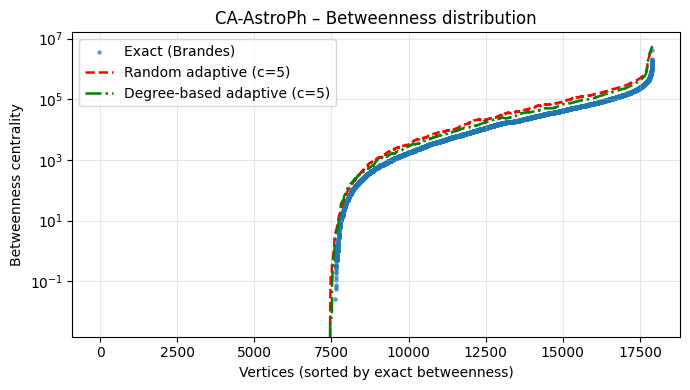

In [53]:
plot_fig1(
    exact_bc     = exact_ca,
    approx_bc_rand= approx_ca,        # random adaptive result
    approx_bc_deg = approx_ca_deg,    # degree-based adaptive result
    title_suffix  = "CA-AstroPh"
)

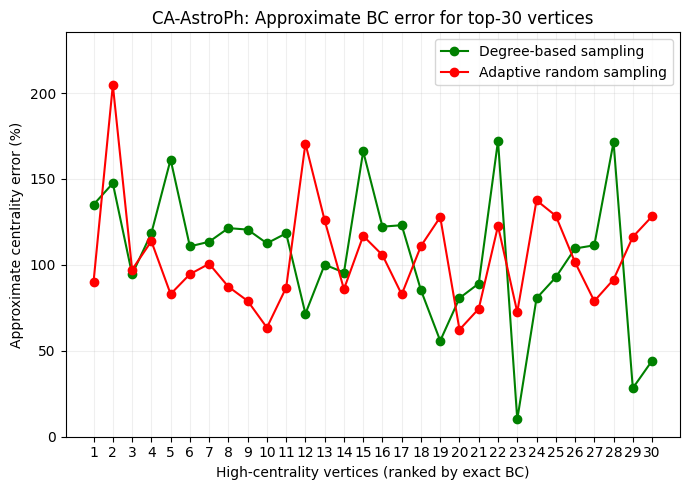

In [54]:
plot_bc_error_two_methods(
    exact_bc=exact_ca,
    approx_bc_deg=approx_ca_deg,
    approx_bc_rand=approx_ca,
    top_k=30,
    title="CA-AstroPh: Approximate BC error for top-30 vertices"
)

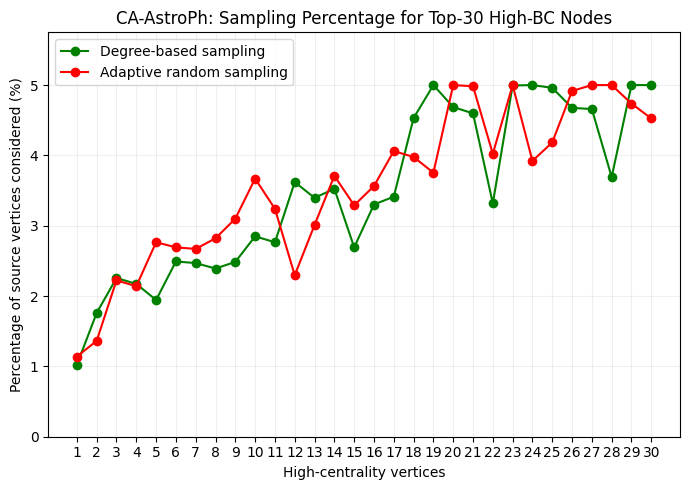

In [55]:
plot_bfs_percentages(
    G_ca,
    exact_ca,
    k_used_ca_deg,
    k_used_ca,
    top_k=30,
    title="CA-AstroPh: Sampling Percentage for Top-30 High-BC Nodes"
)

In [56]:
def compute_average_error(exact_bc, approx_bc):
    errors = []
    for v in exact_bc:
        e = exact_bc[v]
        if e == 0:
            continue   # ignore zero exact BC to avoid division by zero
        err = abs(approx_bc[v] - e) / e 
        errors.append(err)
    return np.mean(errors)


avg_err_rand = compute_average_error(exact_ca, approx_ca)
avg_err_deg  = compute_average_error(exact_ca, approx_ca_deg)

print("Average error (adaptive random):", avg_err_rand)
print("Average error (degree-based adaptive):", avg_err_deg)

Average error (adaptive random): 1.0265427233345228
Average error (degree-based adaptive): 0.6785206972594503


P2P dataset

In [58]:
p2p_path = "../data/real-world-new/p2p-Gnutella31_directed.txt"  
G_p2p = load_graph(p2p_path, directed=True, use_giant_component=True)
n_p2p = G_p2p.number_of_nodes()
print("P2P-Gnutella31:", n_p2p, G_p2p.number_of_edges())

[load] full graph from ../data/real-world-new/p2p-Gnutella31_directed.txt: n=62586, m=147892
[load] use giant WCC: n=62561, m=147878
P2P-Gnutella31: 62561 147878


In [59]:
c_val = 5.0
cutoff_factor = 20

approx_p2p, k_used_p2p, bfs_used_p2p = approx_bc_algorithm1_random(
    G_p2p,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[P2P-Gnutella31 approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_p2p}, "
    f"avg samples per node = {np.mean(list(k_used_p2p.values())):.2f}"
)

[approx] adaptive + cutoff: max 3128 BFS runs (n/20), c=5.0
[approx] BFS 10/3128, remaining not-done vertices: 62561
[approx] BFS 20/3128, remaining not-done vertices: 62561
[approx] BFS 30/3128, remaining not-done vertices: 62561
[approx] BFS 40/3128, remaining not-done vertices: 62561
[approx] BFS 50/3128, remaining not-done vertices: 62561
[approx] BFS 60/3128, remaining not-done vertices: 62561
[approx] BFS 70/3128, remaining not-done vertices: 62561
[approx] BFS 80/3128, remaining not-done vertices: 62561
[approx] BFS 90/3128, remaining not-done vertices: 62561
[approx] BFS 100/3128, remaining not-done vertices: 62561
[approx] BFS 110/3128, remaining not-done vertices: 62561
[approx] BFS 120/3128, remaining not-done vertices: 62561
[approx] BFS 130/3128, remaining not-done vertices: 62561
[approx] BFS 140/3128, remaining not-done vertices: 62561
[approx] BFS 150/3128, remaining not-done vertices: 62561
[approx] BFS 160/3128, remaining not-done vertices: 62561
[approx] BFS 170/3128

In [60]:
approx_p2p_deg, k_used_p2p_deg, bfs_used_p2p_deg = approx_bc_algorithm1_degree_based(
    G_p2p,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[P2P-Gnutella31 approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_p2p_deg}, "
    f"avg samples per node = {np.mean(list(k_used_p2p_deg.values())):.2f}"
)

[approx-alpha-degree] max 3128 BFS runs, c=5.0, alpha=1.0
[approx-alpha-degree] BFS 10/3128, remaining=62561
[approx-alpha-degree] BFS 20/3128, remaining=62561
[approx-alpha-degree] BFS 30/3128, remaining=62561
[approx-alpha-degree] BFS 40/3128, remaining=62561
[approx-alpha-degree] BFS 50/3128, remaining=62561
[approx-alpha-degree] BFS 60/3128, remaining=62561
[approx-alpha-degree] BFS 70/3128, remaining=62561
[approx-alpha-degree] BFS 80/3128, remaining=62561
[approx-alpha-degree] BFS 90/3128, remaining=62561
[approx-alpha-degree] BFS 100/3128, remaining=62561
[approx-alpha-degree] BFS 110/3128, remaining=62561
[approx-alpha-degree] BFS 120/3128, remaining=62561
[approx-alpha-degree] BFS 130/3128, remaining=62561
[approx-alpha-degree] BFS 140/3128, remaining=62561
[approx-alpha-degree] BFS 150/3128, remaining=62561
[approx-alpha-degree] BFS 160/3128, remaining=62561
[approx-alpha-degree] BFS 170/3128, remaining=62561
[approx-alpha-degree] BFS 180/3128, remaining=62561
[approx-alpha-d

In [61]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_p2p = nx.betweenness_centrality(G_p2p, normalized=False)
t1 = perf_counter()
print(f"[P2P-Gnutella31 exact] finished in {t1 - t0:.2f}s")

[P2P-Gnutella31 exact] finished in 4017.99s


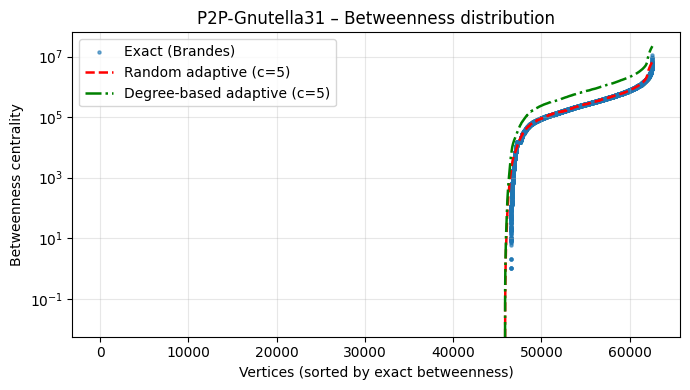

In [62]:
plot_fig1(
    exact_bc      = exact_p2p,
    approx_bc_rand= approx_p2p,        # random adaptive result
    approx_bc_deg = approx_p2p_deg,    # degree-based adaptive result
    title_suffix  = "P2P-Gnutella31"
)

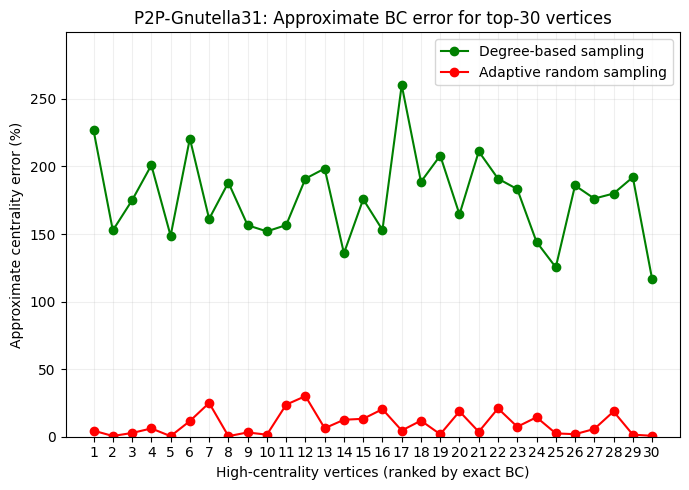

In [63]:
plot_bc_error_two_methods(
    exact_bc=exact_p2p,
    approx_bc_deg=approx_p2p_deg,
    approx_bc_rand=approx_p2p,
    top_k=30,
    title="P2P-Gnutella31: Approximate BC error for top-30 vertices"
)

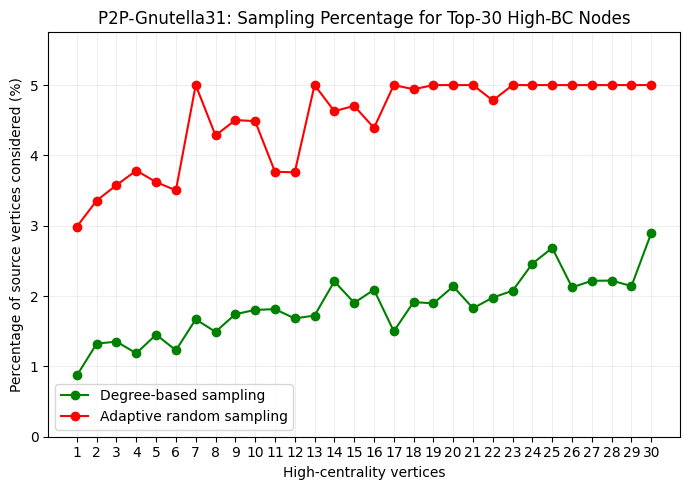

In [64]:
plot_bfs_percentages(
    G_p2p,
    exact_p2p,
    k_used_p2p_deg,
    k_used_p2p,
    top_k=30,
    title="P2P-Gnutella31: Sampling Percentage for Top-30 High-BC Nodes"
)

In [65]:
avg_err_rand_p2p = compute_average_error(exact_p2p, approx_p2p)
avg_err_deg_p2p  = compute_average_error(exact_p2p, approx_p2p_deg)

print("Average error (adaptive random):", avg_err_rand_p2p)
print("Average error (degree-based adaptive):", avg_err_deg_p2p)

Average error (adaptive random): 0.3721589206409467
Average error (degree-based adaptive): 1.7390078518489616


email enron directed dataset

In [176]:
enron_path = "../data/real-world-new/email-Enron_directed.txt"  
G_enron = load_graph(enron_path, directed=True, use_giant_component=True)
n_enron = G_enron.number_of_nodes()
print("Email-Enron:", n_enron, G_enron.number_of_edges())

[load] full graph from ../data/real-world-new/email-Enron_directed.txt: n=36692, m=367662
[load] use giant WCC: n=33696, m=361622
Email-Enron: 33696 361622


In [177]:
c_val = 5.0
cutoff_factor = 20

approx_enron, k_used_enron, bfs_used_enron = approx_bc_algorithm1_random(
    G_enron,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[Email-Enron approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_enron}, "
    f"avg samples per node = {np.mean(list(k_used_enron.values())):.2f}"
)

[approx] adaptive + cutoff: max 1684 BFS runs (n/20), c=5.0
[approx] BFS 10/1684, remaining not-done vertices: 33696
[approx] BFS 20/1684, remaining not-done vertices: 33696
[approx] BFS 30/1684, remaining not-done vertices: 33696
[approx] BFS 40/1684, remaining not-done vertices: 33696
[approx] BFS 50/1684, remaining not-done vertices: 33696
[approx] BFS 60/1684, remaining not-done vertices: 33695
[approx] BFS 70/1684, remaining not-done vertices: 33693
[approx] BFS 80/1684, remaining not-done vertices: 33693
[approx] BFS 90/1684, remaining not-done vertices: 33692
[approx] BFS 100/1684, remaining not-done vertices: 33691
[approx] BFS 110/1684, remaining not-done vertices: 33691
[approx] BFS 120/1684, remaining not-done vertices: 33690
[approx] BFS 130/1684, remaining not-done vertices: 33689
[approx] BFS 140/1684, remaining not-done vertices: 33688
[approx] BFS 150/1684, remaining not-done vertices: 33686
[approx] BFS 160/1684, remaining not-done vertices: 33686
[approx] BFS 170/1684

In [178]:
approx_enron_deg, k_used_enron_deg, bfs_used_enron_deg = approx_bc_algorithm1_degree_based(
    G_enron,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[Email-Enron approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_enron_deg}, "
    f"avg samples per node = {np.mean(list(k_used_enron_deg.values())):.2f}"
)

[approx-alpha-degree] max 1684 BFS runs, c=5.0, alpha=1.0
[approx-alpha-degree] BFS 10/1684, remaining=33696
[approx-alpha-degree] BFS 20/1684, remaining=33696
[approx-alpha-degree] BFS 30/1684, remaining=33696
[approx-alpha-degree] BFS 40/1684, remaining=33696
[approx-alpha-degree] BFS 50/1684, remaining=33696
[approx-alpha-degree] BFS 60/1684, remaining=33696
[approx-alpha-degree] BFS 70/1684, remaining=33696
[approx-alpha-degree] BFS 80/1684, remaining=33696
[approx-alpha-degree] BFS 90/1684, remaining=33695
[approx-alpha-degree] BFS 100/1684, remaining=33695
[approx-alpha-degree] BFS 110/1684, remaining=33695
[approx-alpha-degree] BFS 120/1684, remaining=33694
[approx-alpha-degree] BFS 130/1684, remaining=33694
[approx-alpha-degree] BFS 140/1684, remaining=33692
[approx-alpha-degree] BFS 150/1684, remaining=33690
[approx-alpha-degree] BFS 160/1684, remaining=33689
[approx-alpha-degree] BFS 170/1684, remaining=33689
[approx-alpha-degree] BFS 180/1684, remaining=33688
[approx-alpha-d

In [179]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_enron = nx.betweenness_centrality(G_enron, normalized=False)
t1 = perf_counter()
print(f"[Email-Enron exact] finished in {t1 - t0:.2f}s")

[Email-Enron exact] finished in 2822.27s


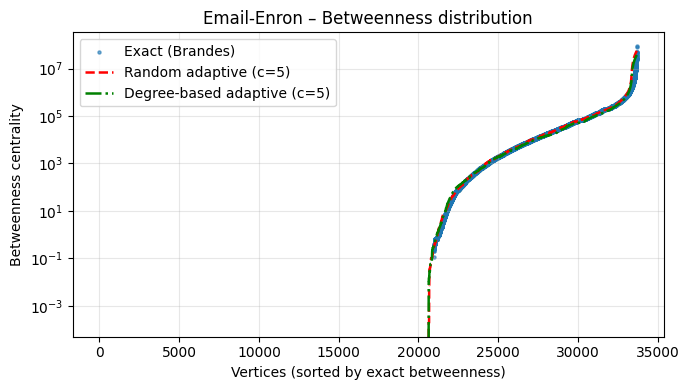

In [199]:
plot_fig1(
    exact_bc      = exact_enron,
    approx_bc_rand= approx_enron,        # random adaptive result
    approx_bc_deg = approx_enron_deg,    # degree-based adaptive result
    title_suffix  = "Email-Enron"
)

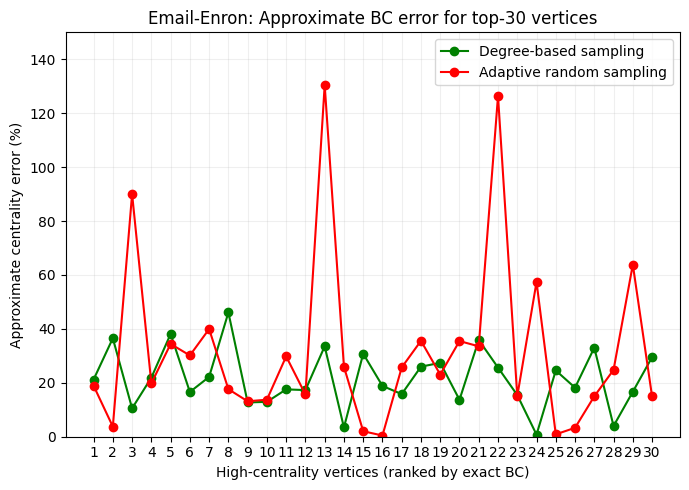

In [181]:
plot_bc_error_two_methods(
    exact_bc=exact_enron,
    approx_bc_deg=approx_enron_deg,
    approx_bc_rand=approx_enron,
    top_k=30,
    title="Email-Enron: Approximate BC error for top-30 vertices"
)

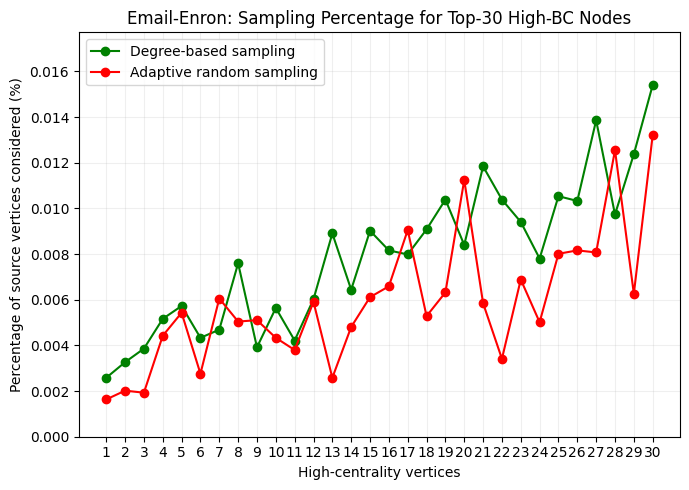

In [182]:
plot_bfs_percentages(
    G_enron,
    exact_enron,
    k_used_enron_deg,
    k_used_enron,
    top_k=30,
    title="Email-Enron: Sampling Percentage for Top-30 High-BC Nodes"
)

In [183]:
avg_err_rand_enron = compute_average_error(exact_enron, approx_enron)
avg_err_deg_enron  = compute_average_error(exact_enron, approx_enron)

print("Average error (adaptive random):", avg_err_rand_enron)
print("Average error (degree-based adaptive):", avg_err_deg_enron)

Average error (adaptive random): 0.6470552368254622
Average error (degree-based adaptive): 0.6470552368254622


Facebook Large Page-Page Network
https://snap.stanford.edu/data/facebook-large-page-page-network.html

In [191]:
path = "../data/real-world-new/musae_facebook_edges.csv"
G_fb = load_csv_edge_list(path, directed=False)

print(G_fb.number_of_nodes(), G_fb.number_of_edges())

Facebook CSV graph: n=22470, m=171002
22470 171002


In [192]:
c_val = 5.0
cutoff_factor = 20

approx_fb, k_used_fb, bfs_used_fb = approx_bc_algorithm1_random(
    G_fb,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[Facebook approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_fb}, "
    f"avg samples per node = {np.mean(list(k_used_fb.values())):.2f}"
)

[approx] adaptive + cutoff: max 1123 BFS runs (n/20), c=5.0
[approx] BFS 10/1123, remaining not-done vertices: 22470
[approx] BFS 20/1123, remaining not-done vertices: 22470
[approx] BFS 30/1123, remaining not-done vertices: 22470
[approx] BFS 40/1123, remaining not-done vertices: 22470
[approx] BFS 50/1123, remaining not-done vertices: 22470
[approx] BFS 60/1123, remaining not-done vertices: 22469
[approx] BFS 70/1123, remaining not-done vertices: 22468
[approx] BFS 80/1123, remaining not-done vertices: 22468
[approx] BFS 90/1123, remaining not-done vertices: 22468
[approx] BFS 100/1123, remaining not-done vertices: 22468
[approx] BFS 110/1123, remaining not-done vertices: 22468
[approx] BFS 120/1123, remaining not-done vertices: 22466
[approx] BFS 130/1123, remaining not-done vertices: 22466
[approx] BFS 140/1123, remaining not-done vertices: 22466
[approx] BFS 150/1123, remaining not-done vertices: 22466
[approx] BFS 160/1123, remaining not-done vertices: 22465
[approx] BFS 170/1123

In [193]:
approx_fb_deg, k_used_fb_deg, bfs_used_fb_deg = approx_bc_algorithm1_degree_based(
    G_fb,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[Facebook approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_fb_deg}, "
    f"avg samples per node = {np.mean(list(k_used_fb_deg.values())):.2f}"
)

[approx-alpha-degree] max 1123 BFS runs, c=5.0, alpha=1.0
[approx-alpha-degree] BFS 10/1123, remaining=22470
[approx-alpha-degree] BFS 20/1123, remaining=22470
[approx-alpha-degree] BFS 30/1123, remaining=22470
[approx-alpha-degree] BFS 40/1123, remaining=22470
[approx-alpha-degree] BFS 50/1123, remaining=22470
[approx-alpha-degree] BFS 60/1123, remaining=22468
[approx-alpha-degree] BFS 70/1123, remaining=22468
[approx-alpha-degree] BFS 80/1123, remaining=22468
[approx-alpha-degree] BFS 90/1123, remaining=22468
[approx-alpha-degree] BFS 100/1123, remaining=22468
[approx-alpha-degree] BFS 110/1123, remaining=22467
[approx-alpha-degree] BFS 120/1123, remaining=22466
[approx-alpha-degree] BFS 130/1123, remaining=22466
[approx-alpha-degree] BFS 140/1123, remaining=22466
[approx-alpha-degree] BFS 150/1123, remaining=22466
[approx-alpha-degree] BFS 160/1123, remaining=22466
[approx-alpha-degree] BFS 170/1123, remaining=22466
[approx-alpha-degree] BFS 180/1123, remaining=22466
[approx-alpha-d

In [194]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_fb = nx.betweenness_centrality(G_fb, normalized=False)
t1 = perf_counter()
print(f"[Facebook Large Page-Page Network exact] finished in {t1 - t0:.2f}s")

[Facebook Large Page-Page Network exact] finished in 1615.72s


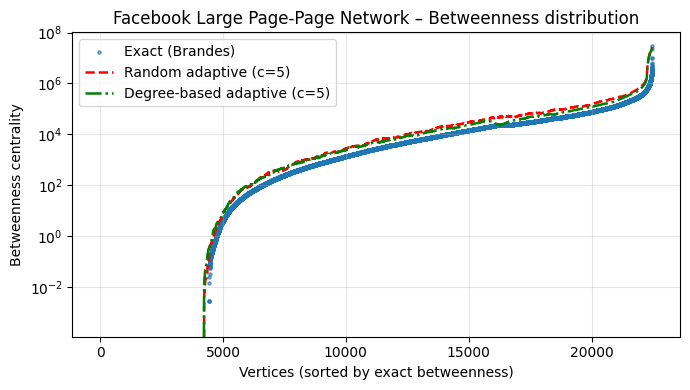

In [200]:
plot_fig1(
    exact_bc     = exact_fb,
    approx_bc_rand= approx_fb,        # random adaptive result
    approx_bc_deg = approx_fb_deg,    # degree-based adaptive result
    title_suffix  = "Facebook Large Page-Page Network"
)

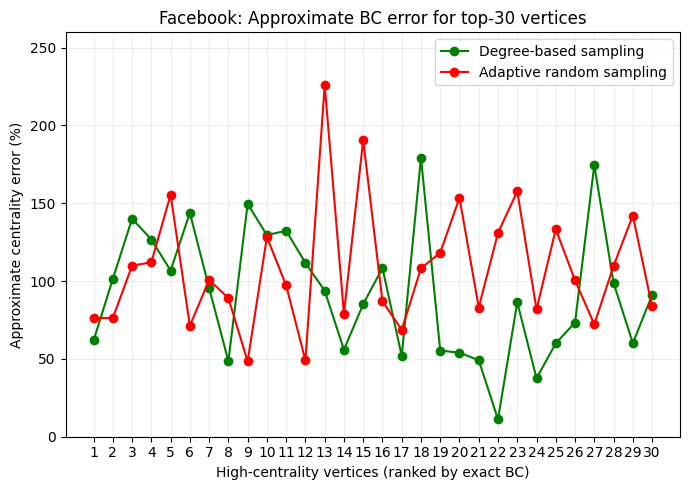

In [201]:
plot_bc_error_two_methods(
    exact_bc=exact_fb,
    approx_bc_deg=approx_fb_deg,
    approx_bc_rand=approx_fb,
    top_k=30,
    title="Facebook: Approximate BC error for top-30 vertices"
)

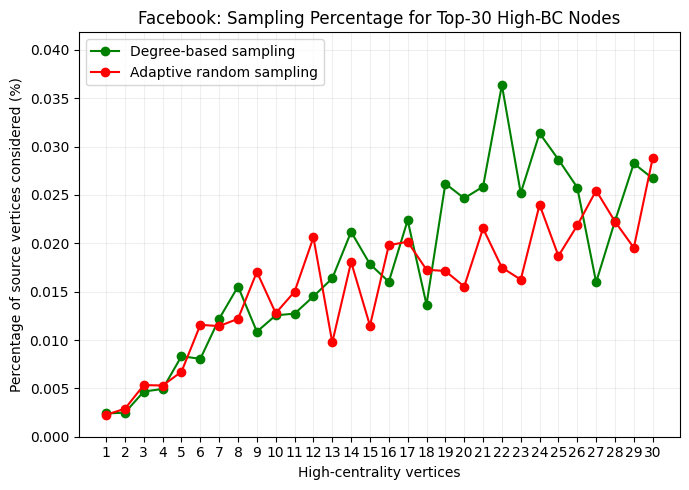

In [202]:
plot_bfs_percentages(
    G_fb,
    exact_fb,
    k_used_fb_deg,
    k_used_fb,
    top_k=30,
    title="Facebook: Sampling Percentage for Top-30 High-BC Nodes"
)

In [203]:
avg_err_rand_enron = compute_average_error(exact_enron, approx_enron)
avg_err_deg_enron  = compute_average_error(exact_enron, approx_enron)

print("Average error (adaptive random):", avg_err_rand_enron)
print("Average error (degree-based adaptive):", avg_err_deg_enron)

Average error (adaptive random): 0.6470552368254622
Average error (degree-based adaptive): 0.6470552368254622


Twitter
https://snap.stanford.edu/data/ego-Twitter.html

In [24]:
path = "../data/real-world-new/twitter_combined.txt"
G_twitter= load_graph(path, directed=True)
print(G_twitter.number_of_nodes(), G_twitter.number_of_edges())

[load] full graph from ../data/real-world-new/twitter_combined.txt: n=81306, m=1768149
81306 1768149


In [25]:
c_val = 5.0
cutoff_factor = 20

approx_twitter, k_used_twitter, bfs_used_twitter = approx_bc_algorithm1_random(
    G_twitter,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[Twitter approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_twitter}, "
    f"avg samples per node = {np.mean(list(k_used_twitter.values())):.2f}"
)

[approx] adaptive + cutoff: max 4065 BFS runs (n/20), c=5.0
[approx] BFS 10/4065, remaining not-done vertices: 81306
[approx] BFS 20/4065, remaining not-done vertices: 81306
[approx] BFS 30/4065, remaining not-done vertices: 81306
[approx] BFS 40/4065, remaining not-done vertices: 81305
[approx] BFS 50/4065, remaining not-done vertices: 81305
[approx] BFS 60/4065, remaining not-done vertices: 81305
[approx] BFS 70/4065, remaining not-done vertices: 81304
[approx] BFS 80/4065, remaining not-done vertices: 81304
[approx] BFS 90/4065, remaining not-done vertices: 81303
[approx] BFS 100/4065, remaining not-done vertices: 81303
[approx] BFS 110/4065, remaining not-done vertices: 81303
[approx] BFS 120/4065, remaining not-done vertices: 81303
[approx] BFS 130/4065, remaining not-done vertices: 81302
[approx] BFS 140/4065, remaining not-done vertices: 81302
[approx] BFS 150/4065, remaining not-done vertices: 81302
[approx] BFS 160/4065, remaining not-done vertices: 81302
[approx] BFS 170/4065

In [26]:
approx_twitter_deg, k_used_twitter_deg, bfs_used_twitter_deg = approx_bc_algorithm1_degree_based(
    G_twitter,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[Twitter approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_twitter_deg}, "
    f"avg samples per node = {np.mean(list(k_used_twitter_deg.values())):.2f}"
)

[approx-alpha-degree] max 4065 BFS runs, c=5.0, alpha=1.0
[approx-alpha-degree] BFS 10/4065, remaining=81306
[approx-alpha-degree] BFS 20/4065, remaining=81306
[approx-alpha-degree] BFS 30/4065, remaining=81306
[approx-alpha-degree] BFS 40/4065, remaining=81305
[approx-alpha-degree] BFS 50/4065, remaining=81305
[approx-alpha-degree] BFS 60/4065, remaining=81304
[approx-alpha-degree] BFS 70/4065, remaining=81304
[approx-alpha-degree] BFS 80/4065, remaining=81304
[approx-alpha-degree] BFS 90/4065, remaining=81302
[approx-alpha-degree] BFS 100/4065, remaining=81302
[approx-alpha-degree] BFS 110/4065, remaining=81302
[approx-alpha-degree] BFS 120/4065, remaining=81302
[approx-alpha-degree] BFS 130/4065, remaining=81302
[approx-alpha-degree] BFS 140/4065, remaining=81302
[approx-alpha-degree] BFS 150/4065, remaining=81301
[approx-alpha-degree] BFS 160/4065, remaining=81301
[approx-alpha-degree] BFS 170/4065, remaining=81301
[approx-alpha-degree] BFS 180/4065, remaining=81298
[approx-alpha-d

In [27]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_twitter = nx.betweenness_centrality(G_twitter, normalized=False)
t1 = perf_counter()
print(f"[Twitter exact] finished in {t1 - t0:.2f}s")

[Twitter exact] finished in 29470.98s


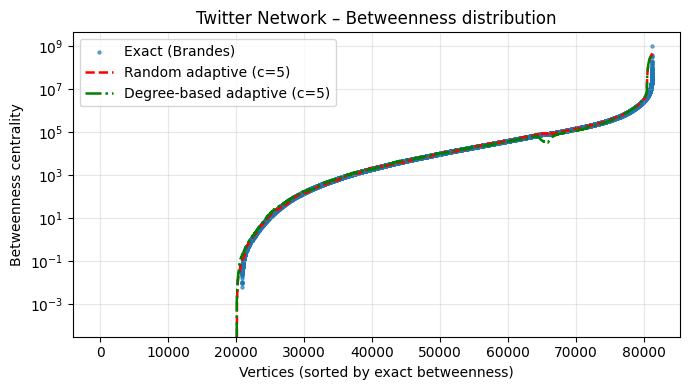

In [28]:
plot_fig1(
    exact_bc     = exact_twitter,
    approx_bc_rand= approx_twitter,        # random adaptive result
    approx_bc_deg = approx_twitter_deg,    # degree-based adaptive result
    title_suffix  = "Twitter Network"
)

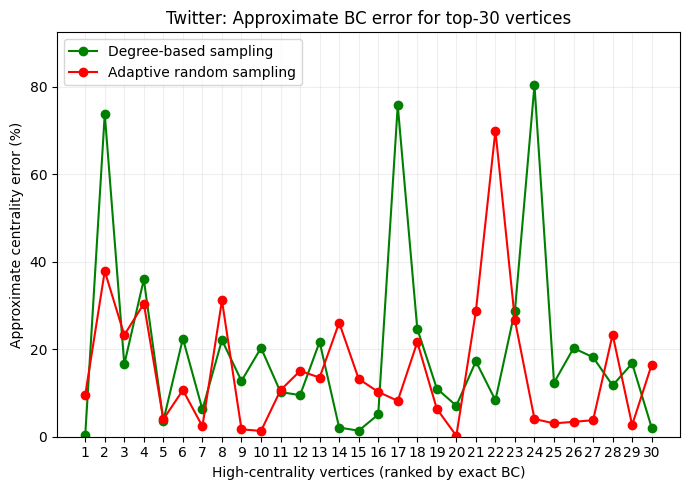

In [ ]:
plot_bc_error_two_methods(
    exact_bc=exact_twitter,
    approx_bc_deg=approx_twitter_deg,
    approx_bc_rand=approx_twitter,
    top_k=30,
    title="Twitter: Approximate BC error for top-30 vertices"
)

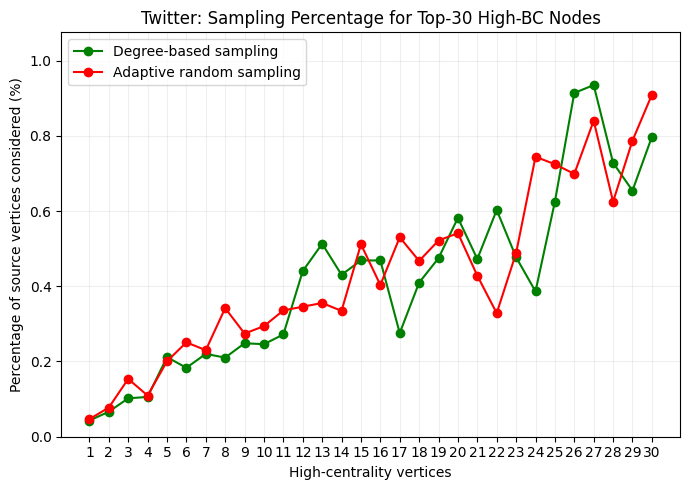

In [35]:
plot_bfs_percentages(
    G_twitter,
    exact_twitter,
    k_used_twitter_deg,
    k_used_twitter,
    top_k=30,
    title="Twitter: Sampling Percentage for Top-30 High-BC Nodes"
)

In [32]:
def compute_average_error(exact_bc, approx_bc):
    errors = []
    for v in exact_bc:
        e = exact_bc[v]
        if e == 0:
            continue   # ignore zero exact BC to avoid division by zero
        err = abs(approx_bc[v] - e) / e 
        errors.append(err)
    return np.mean(errors)
avg_err_rand_twitter = compute_average_error(exact_twitter, approx_twitter)
avg_err_deg_twitter  = compute_average_error(exact_twitter, approx_twitter_deg)

print("Average error (adaptive random):", avg_err_rand_twitter)
print("Average error (degree-based adaptive):", avg_err_deg_twitter)

Average error (adaptive random): 0.8688379339876742
Average error (degree-based adaptive): 0.823879040095754
